# Exploring Boston's Airbnb Trends: Insights from Data
Boston is a city that I've been longing to visit, and as a budget-conscious traveler, Airbnb is my go-to accommodation choice. With a plethora of unique and affordable options available, it's hard to resist the appeal. That's why I've decided to dive into the data of Boston's Airbnb market, analyzing everything from the number of listings to pricing and neighborhood vibes. By the end of this post, not only will you have a better understanding of the city of Boston, but you'll also gain insights into the fascinating world of data science.


<a id="0"></a> <br>
 ## Table of Contents  
1. [The CRISP-DM Approach](#1)     
1. [The Datasets](#2) 
1. [Business Understanding](#3)
    1. [Business Questions](#4)
1. [Data Understanding](#5)
1. [Data Preparation - Initial NaN processing](#6)     
1. [Questions 1 and 2](#7)     
    1. [Data preparation](#8)
        1. [Answering question #1](#9)   
        1. [Answering question #2](#10)     
1. [Question 3: What is the vibe of each neighborhood based on the neighborhood overview?](#11)
    1. [Data Preparation](#12)     
    1. [Modeling](#13)
    1. [Evaluation - Answering the question](#14)
1. [Question 4: Can we predict the price of Boston Airbnbs?](#15)
    1. [Data Preparation](#16)     
    1. [Modeling and Evaluation](#17)
    1. [Answering the question](#18)
1. [Conclusion](#19)
  



<a id="1"></a>
## CRISP-DM Analysis

To perform this analysis, I will be using the CRISP-DM approach (Cross-Industry Standard Process for Data Mining) (see more [here](https://www.datascience-pm.com/crisp-dm-2/#:~:text=The%20CRoss%20Industry%20Standard%20Process,Is%20it%20clean%3F)). 
<br>This framework describes specific phases to be followed when analyzing data:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

To ensure clarity and consistency, I will maintain this nomenclature throughout the blog. By doing so, readers can easily associate a particular process with its corresponding phase within the CRISP-DM methodology. Also, I won't be talking about deployment as it is beyond the scope of this blog.


![alt text](crisp-dm-mc-slide2.png "CRISP-DM analysis")
<br>Source: https://www.sketchbubble.com/en/presentation-crisp-dm.html

<a id="2"></a>
## The Dataset
People from Airbnb gently made available three datasets including thousands of data about Airbnbs in Boston. The datasets can be downloaded ([here](https://www.kaggle.com/datasets/airbnb/boston)). For this analysis, I will only use the dataset named: "listing.csv"

This dataset includes variables related the Airbnb listings, such as price, type (house, apt), review scores, among others.

<a id="3"></a>
## Business Understanding 

I am secure that most people know what Airbnb is. In case you don't know, I asked ChatGPT to describe it in two sentences 🙃
>"Airbnb is an online marketplace that allows people to rent out their homes or other types of lodging to travelers, offering a unique and affordable alternative to traditional hotel accommodations. Guests can search for properties based on their travel dates and location, and book their stay directly through the platform.

<br>In summary, this is a business that makes profits by renting people's houses, apartments, condos, etc. This is a relatively complex business because there are many factors that determine whether a person decides to stay at an Airbnb.

<a id="a"></a>
### Business Questions 
Thus, having this business in mind, what are the inputs we could gain from data? Those business questions should help either owners or costumers about Airbnbs. In this data analysis, I will be answering to the following questions:

1. What is the neighborhood with more listings?
2. Is there a relationship between the amount of listings and availability by neighborhood? 
3. What is the vibe of each neighborhood based on the neighborhood overview?
4. Can we predict the price of Boston Airbnbs?



<a id="5"></a>
## Data Understanding

Let's take a quick look at the data.

In [44]:
# #Importing Necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import KNNImputer
import textwrap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
#Importing the dataset
listing = pd.read_csv('./listings.csv')

#Displaying dataset
listing.head()


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [3]:
#Showing basic info about data type/size
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

<a id="5"></a>
## Data Preparation - Initial NaN processing
Before dealing with specific variables, let's perform a general analysis of the data to see weather there are columns that can be removed.

Amount of columns with Nans in the Listings Dataset:44


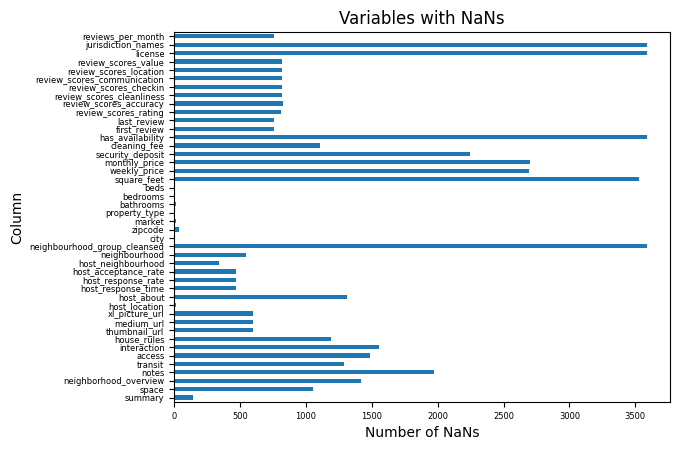

In [4]:
#Printing the amount of columns containing NaNs
print(f"Amount of columns with Nans in the Listings Dataset:{listing.isnull().any().sum()}")

#Storing the amount of non-nans
nan_counts = listing.isna().sum()

# create a bar chart showing the results
nan_counts[nan_counts!=0].plot(kind='barh')
plt.gca().tick_params(axis='both', labelsize=6)
plt.title('Variables with NaNs')
plt.xlabel('Number of NaNs')
plt.ylabel('Column')
plt.show()

We can see that we have five columns including only NaNs. Certainly, those columns do not add anything to our analysis or prediction. Therefore, we can drop them.

In [5]:
#Removing all the columns that contain only NaNs
listing=listing.dropna(axis=1, how='all')

After the first analysis, we could see that:
1. There are a bunch of variables! 
2. This dataset contains both numeric (integer and float) and nominal data;
3. There are several columns with NaNs



<a id="7"></a>
## Questions 1 and 2
<br>The questions of interest are:
1. What is the neighborhood with more listings?
2. Is there a relationship between the amount of listings and availability by neighborhood? 

<a id="8"></a>
### Data preparation: Questions 1 and 2

Since those are relatively simple questions, I will not be performing any modeling, evaluation, or deployment. Those will be further explored when answering the other questions.

In [6]:
#Checking whether we have NaNs in the column: "neighbourhood_cleansed"
print("There is a total of",listing.neighbourhood_cleansed.isna().sum(),"NaNs in the neighbourhood_cleansed column")

#Checking NaNs in the column availability_365
print("There is a total of",listing.availability_365.isna().sum(),"NaNs")

#Storing the neighborhoods
neighborhoods= listing.neighbourhood_cleansed.unique().tolist()

#Printing the amount of different neighborhoods in the column neighbourhood_cleansed
print("There are a total of",len(neighborhoods),"neighborhoods")

There is a total of 0 NaNs in the neighbourhood_cleansed column
There is a total of 0 NaNs
There are a total of 25 neighborhoods


<a id="3"></a>
We have a total of 25 neighborhoods. Now, let's see how many listings each neighborhood has. 

Text(200, 18, 'Listing Amount: 201 +')

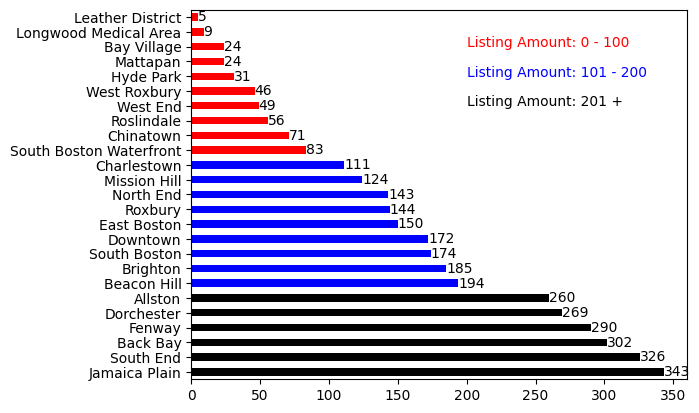

In [7]:

# Storing the keys using value_counts to ensure the same order when ploting the colors later.  
neighbourhood_sorted=listing.neighbourhood_cleansed.value_counts()
#creating a dictionary and storing different colors given the amount of listings by neighborhood
neighb_col_amount = {neighb: 'red' if amount < 101 else 'blue' if amount <= 200 else 'black' 
                    for neighb, amount in zip(neighbourhood_sorted.keys(), neighbourhood_sorted)}

#Ploting the amount of listings and assigning colors using the previously created color list.
plot_lists_by_neighborhood_color=neighbourhood_sorted.plot.barh(color=neighb_col_amount.values())
plot_lists_by_neighborhood_color.bar_label(plot_lists_by_neighborhood_color.containers[0])
plot_lists_by_neighborhood_color.set_ylabel(None)
plot_lists_by_neighborhood_color.annotate('Listing Amount: 0 - 100',xy=(200,22),color='red')
plot_lists_by_neighborhood_color.annotate('Listing Amount: 101 - 200',xy=(200,20),color='blue')
plot_lists_by_neighborhood_color.annotate('Listing Amount: 201 +',xy=(200,18),color='black')



<a id="9"></a>
#### Answering question #1
Answering our first question, the neighborhoods with more listings are: Jamaica Plain(343), South End (326), Back Bay (302), Fenway(290), Dorchester (269), and Allston (260). 

Now, let's plot the availability in the previous year. In which, 365 means that the location was available to whole year, while 0 means that the place was not available not a single day in the previous year.

Text(175, 2, 'Listing Amount: 201 +')

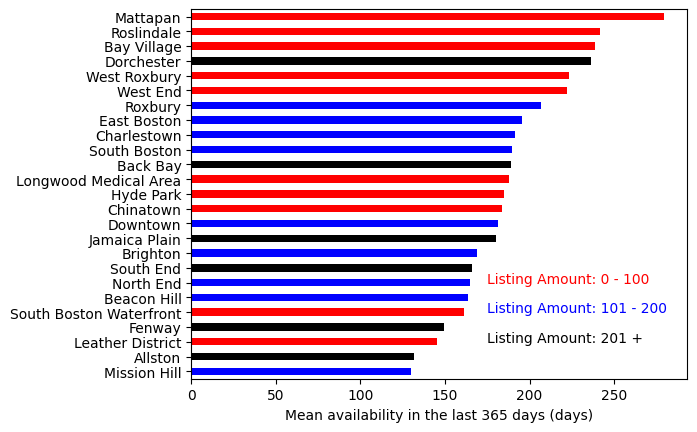

In [8]:
#Creating a dicionatry to store the amount of days available by neighborhood
days_available={}

#Iterating over the neighborhoods and storing the mean availability 
days_available = pd.Series({neigh: listing.availability_365[listing.neighbourhood_cleansed == neigh].mean() for neigh in neighborhoods})
days_available=days_available.sort_values()

#Creating a list of colors for each neighborhood given the assigned colors before
colors_list = [neighb_col_amount[neigh] for neigh in days_available.keys()]

#Ploting the availability plot and assigning the colors according to the amount of listings
plot_availability=days_available.plot.barh(color=colors_list)
plot_availability.set_xlabel('Mean availability in the last 365 days (days)')
plot_availability.annotate('Listing Amount: 0 - 100',xy=(175,6),color='red')
plot_availability.annotate('Listing Amount: 101 - 200',xy=(175,4),color='blue')
plot_availability.annotate('Listing Amount: 201 +',xy=(175,2),color='black')



When analyzing the graph and the colors. We can see that, although the colors are spread out, the places with fewer listings (blue and red) had higher availability. One exception is Dorchester that was listed among the places with the most availability. Indicating that although the large amount of listings, people stayed there much less than other places. To further test this correlation between amount of listing and availability, we can quickly run a linear correlation.


The correlation coeficient is: -0.35
The p-value is: 0.08


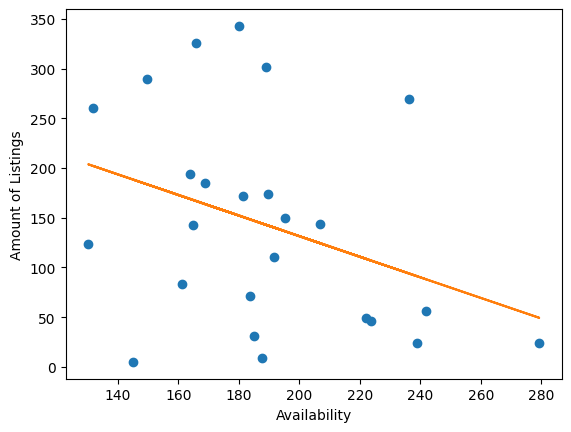

In [9]:
#Creating and populating the lists with the amount of listings and availability
X = [days_available[neigh] for neigh in neighborhoods]
Y = [neighbourhood_sorted[neigh] for neigh in neighborhoods]

#Plotting a scaterplot of the two variables
plt.plot(X, Y, 'o')
plt.xlabel('Availability')
plt.ylabel('Amount of Listings')

#obtain s (slope) and i(intercept) of linear regression 
s, i = np.polyfit(X, Y, 1)

#add linear regression line to scatterplot 
plt.plot(X, float(s)*np.float64(X)+i)

#Printing the pearson correlation
r = pearsonr(X,Y)
print(f"The correlation coeficient is: {round(r[0],2)}\nThe p-value is: {round(r[1],2)}")


<a id="10"></a>
#### Answering question #2
As we visually grasped before, we can see that the variables are negatively correlated (-0.35). However, the p-value was greater than 0.05 and the sample size for this analysis is quite small (n=25). Therefore, I would be skeptical to confirm that there is a significant correlation between the amount of listings and place availability.

Still, those results are interesting. This trend shows that if a neighborhood has more listings, those places would have higher booking (less availability). This makes sense because, in theory, given the higher amount of listings, there is a higher demand of places in those neighborhoods. 

<a id="11"></a>
## Question 3: What is the vibe of each neighborhood based on the neighborhood overview?

Now let's see whether we can have some understanding of what each neighborhood looks like based on the overview provided by the owners. A relatively simple way to do that, is by performing a natural language processing analysis. Specifically, a trained model will "read" the reviews and will summarize the biggest points for each neighborhood based on the analysis of the reviews about that neighborhood. 

<a id="12"></a>
### Data Preparation

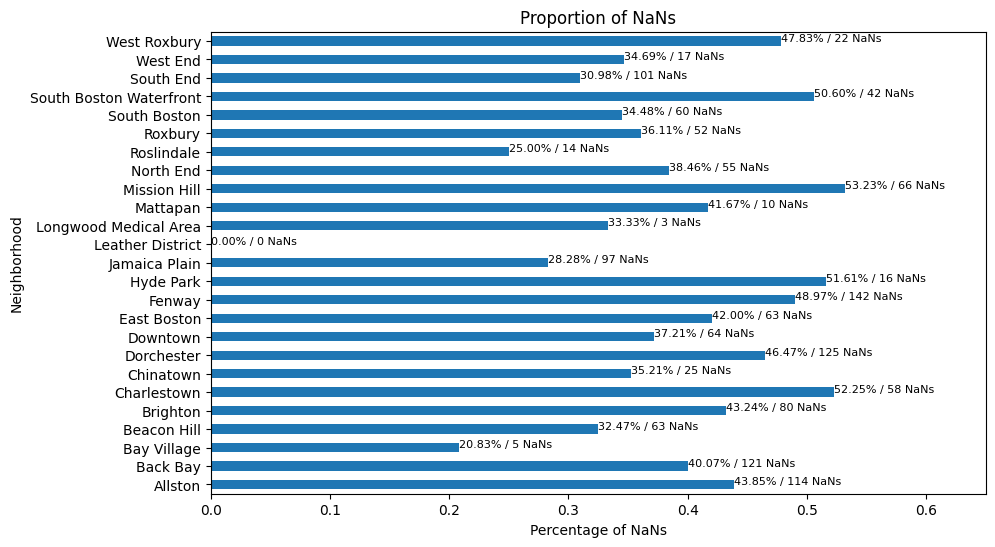

In [10]:
#Analyzing NaNs

# Replace NaN values with empty strings
listing['neighbourhood_overview'] = listing['neighborhood_overview'].fillna('')

# group the listings by neighborhood
neighborhood_groups = listing.groupby('neighbourhood_cleansed')

# count the number of NaNs/non-Nans data in the neighborhood overview column for each neighborhood
nans = neighborhood_groups['neighborhood_overview'].apply(lambda x: x.isna().sum())
notnans = neighborhood_groups['neighborhood_overview'].apply(lambda x: x.notna().sum())

# calculate the proportion of NaNs in the neighborhood overview column for each neighborhood
prop_nans = neighborhood_groups['neighborhood_overview'].apply(lambda x: x.isna().mean())

# create a dataframe with the count and proportion of NaNs
nan_counts = pd.DataFrame({'count_NaNs': nans, 'proportion_NaNs': prop_nans})

# create the plot
ax = nan_counts['proportion_NaNs'].plot(kind='barh', title='Proportion of NaNs', xlabel='Percentage of NaNs',
                                         ylabel='Neighborhood', figsize=(10, 6))
ax.set_xlim(0, 0.65)

# add the bar labels
for i, (count, prop) in enumerate(zip(nan_counts['count_NaNs'], nan_counts['proportion_NaNs'])):
    ax.text(prop, i, f'{prop*100:.2f}% / {count} NaNs', color='black', fontsize=8)

# show the plot
plt.show()

The number of NaNs in this column is relatively high (~30-45%). However, since we are analyzing text here, there is not much we can do to input new values. However, we should replace those NaNs with another string or empty space to perform the analysis.

Also, we should be aware that the results could be biased because the column contains NaNs. Still, we should be able to, at least, have some idea about each neighborhood.

In [11]:
#Creating a dataset containing the nighborhood and overview
text_analysis = listing[['neighborhood_overview','neighbourhood_cleansed']]

#Replacing the nans with an empty space
text_analysis=text_analysis.fillna('')

<a id="13"></a>
### Data Modeling
As I alluded before, NLP refers to machine learning techniques that allow computers to make sense of text naturally. For instance, using the context to evaluate sentences instead of only using isolated words.
In our analysis, we will be using a model (t5-base) from the Hugging Face library that was previously trained using a diverse range of sources, including books, articles, and websites. The model will analyze the text and will return us a summary containing the most important information from all the overviews for the neighborhoods.

In [14]:

### WARNING: THIS MIGHT TAKE A FEW MINUTES TO RUN

# Load the pre-trained model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
#The tokenizer only generates and analyzes 1024. That means that some texts were not considered
tokenizer = AutoTokenizer.from_pretrained("t5-base",model_max_length=1024)
# Define the generation configuration
gen_config = {
    "max_length": 150,
    "num_beams": 4,
    "early_stopping": True
}
# Load the summarization pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer,config=gen_config)

#Creating dictionary to store the results
review_summaries={neigh: [] for neigh in neighborhoods}

#Iterating through all the texts and storing the summary in a dictionary
for neigh in review_summaries.keys():
    text=text_analysis['neighborhood_overview'][text_analysis['neighbourhood_cleansed']==neigh]
    # Combine all the texts into a single string
    text = ' '.join(text)

    # Encode the text using the tokenizer
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate the summary using the model
    outputs = model.generate(inputs, max_length=150, num_beams=4, early_stopping=True)
    review_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    review_summaries[neigh]=str(review_summary)



Let's see if our pre-trained model properly summarized the information from the neighborhood overviews.

In [15]:

def print_in_rectangle(text):
    """
    Prints the given text inside a rectangle made of '━' and '┃' characters.

    Args:
        text (str): The text to print inside the rectangle.

    Returns:
        None
    """
    # Wrap the text to a maximum width of 60 characters and split it into lines
    wrapped_text = textwrap.fill(text, width=60)
    text_lines = wrapped_text.split('\n')

    # Determine the length of the longest line
    max_length = max(len(line) for line in text_lines)

    # Print the top line of the rectangle
    print('┏' + '━' * (max_length + 2) + '┓')

    # Print each line of the wrapped text inside the rectangle
    for line in text_lines:
        print('┃ ' + line.center(max_length) + ' ┃')

    # Print the bottom line of the rectangle
    print('┗' + '━' * (max_length + 2) + '┛')


In [16]:
ind_rev=0
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Neighborhood: Roslindale - 42 reviews. Roslindale is a    ┃
┃  primarily residential neighborhood in the city of Boston.   ┃
┃ the neighborhood is well connected via public transportation ┃
┃    to other neighborhoods. a farmer's market held in the     ┃
┃     neighborhood's center is held all summer on Saturday     ┃
┃                          mornings.                           ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [17]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Jamaica Plain - 246 reviews. Jamaica Plain is ┃
┃  a vibrant neighborhood in the city of Boston known for its ┃
┃  sense of community and green space. the community garden,  ┃
┃ the Minton Stable Garden, hosts regular summer cookouts and ┃
┃  houses plots of local gardeners. there are plenty of great ┃
┃   shops, cafes, restaurants and other entertainment within  ┃
┃                      walking distance.                      ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [408]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Neighborhood: Mission Hill - 58 reviews. residents will be ┃
┃     within walking distance to the Longwood Medical Area    ┃
┃  (brigham and womens, Dana Farber, children's hospital and  ┃
┃      Beth Isreal Deconess Hospitals) and Copley Square,     ┃
┃    Prudential Center, the Financial District and Downtown   ┃
┃ Boston. most residents are families, older folks, or quiet, ┃
┃                     young professionals.                    ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [409]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Longwood Medical Area - 6 reviews. Across the  ┃
┃  street from a quiet river walk yet around the corner from   ┃
┃ the chaos in the city. Located about a 25 minute walk to the ┃
┃   green line T station then its a 15 minute train ride to    ┃
┃           downtown/Fanuel hall and Boston Common.            ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [410]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Neighborhood: Bay Village - 19 reviews. the Arlington is a  ┃
┃  five street community of brick town homes in the heart of   ┃
┃ the city. it is nestled between Back Bay, the South End, and ┃
┃   the Theatre District. the area is home to Copley Place,    ┃
┃        Prudential Center and The John Hancock Tower.         ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [411]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Leather District - 5 reviews. 10 minute walk ┃
┃ from Boston Common Park. 2 minute walk to south station -  ┃
┃ the main bus/train terminal, and where the airport shuttle ┃
┃   is. 5 minute walking to downtown crossing - shopping,    ┃
┃   theater, restaurants. 8 minute walk into the harbor -    ┃
┃  beautiful view and nice restaurants. 10 minutes walk to   ┃
┃            Boston Common - my favourite place.             ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [412]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Chinatown - 46 reviews. downtown crossing is a ┃
┃  small part of downtown Boston, located due east of Boston   ┃
┃ Common and west of the Financial District. it features large ┃
┃ department stores as well as restaurants, souvenir sellers,  ┃
┃ general retail establishments, and street vendors. there are ┃
┃     'hubway' or bike rentals near the apartment for your     ┃
┃                  leisurely traveling needs.                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [413]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Neighborhood: North End - 88 reviews. the North End of    ┃
┃ Boston is known for it's Italian history, great restaurants, ┃
┃ and mostly friendly people. if you listen carefully, you can ┃
┃     often hear Italian spoken in the streets, stores and     ┃
┃ restaurants. cottage is located in a safe, quiet residential ┃
┃            area, close to public transportation.             ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [414]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Neighborhood: Roxbury - 92 reviews. the historic South End ┃
┃  of Boston is one for the record books. it is the largest,  ┃
┃ contiguous Victorian neighborhood in the united states. the ┃
┃    neighborhood has been the "hottest" in the real estate   ┃
┃                           market.                           ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [415]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Neighborhood: South End - 225 reviews. the South End is  ┃
┃  North America's largest surviving Victorian residential  ┃
┃    district. it is known for its historic architecture,   ┃
┃   restaurant and art scenes, dog-friendliness, and GLBT   ┃
┃   community. the unit is a 25 minute walk to the Boston   ┃
┃ Common, Fenway Park, and the shopping district on newbury ┃
┃                          street.                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [416]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Neighborhood: Back Bay - 181 reviews. Back Bay is an     ┃
┃ officially recognized neighborhood of Boston, Massachusetts. ┃
┃   it is famous for its rows of Victorian brownstone homes,   ┃
┃     river-side walkways, fashionable shops and excellent     ┃
┃ restaurants. the apartment has sweeping city views from the  ┃
┃                    wall to wall windows.                     ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [417]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: East Boston - 87 reviews. Originally a center ┃
┃ of shipbuilding, east Boston has always been a neighborhood ┃
┃ of immigrants. the blue line is the most regular of all the ┃
┃   lines in the city. to explore downtown proper, one quick  ┃
┃       stop on the Blue Line will put you at Aquarium.       ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [418]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Charlestown - 53 reviews. Charlestown is the ┃
┃ oldest neighborhood in the city and is rich with history.  ┃
┃  the apartment is just a ten minute walk to the Sullivan   ┃
┃ Square T stop. a number of local restaurants and bars are  ┃
┃                  within walking distance.                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [419]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: West End - 32 reviews. TD Garden, home of the  ┃
┃     Bruins and Celtics, is a very short walk, along with     ┃
┃ Massachusetts general hospital, the number 1 hospital in the ┃
┃                           country!                           ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [420]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Neighborhood: Beacon Hill - 131 reviews. 113 Beacon Street  ┃
┃ is an architecturally renovated Victorian brownstone in the  ┃
┃    historic Back Bay district in the heart of Boston. the    ┃
┃  neighborhood is famous for its gas lamps, brick sidewalks,  ┃
┃ and opulent mansions dating back to 1800. Figs, 75 Chestnut, ┃
┃ Bin 26, Tatte, Panificio, Toscanos and more are just around  ┃
┃                         the corner.                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [421]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Neighborhood: Downtown - 108 reviews. the property is    ┃
┃   located in the theater district just blocks from Boston   ┃
┃   Common, Tufts Medical/Dental Center The Opera House and   ┃
┃   Newbury Street. downtown Crossing is a shopping district  ┃
┃ that is due east of Boston Common and west of the Financial ┃
┃   District. it features large department stores as well as  ┃
┃        restaurants, souvenir sellers, general retail        ┃
┃             establishments, and street vendors.             ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [422]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Fenway - 148 reviews. walk to Harvard Medical ┃
┃   School, Longwood Medical Area, museums, parks, theaters,  ┃
┃  nightlife and other venues. walk to Fenway Park, the Rose  ┃
┃    Garden, Museum of Fine Arts, Isabella Stewart Gardner    ┃
┃    Museum, MassArt and the rest of the Fenways Colleges.    ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [423]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Neighborhood: Brighton - 105 reviews. the apartment is   ┃
┃ located on the green line of the T between Boston College  ┃
┃ and Harvard University. it's a 10 minute walk away from a  ┃
┃  variety of restaurants including a Mexican cantina, Thai  ┃
┃   restaurant, and great great tapas place with excellent   ┃
┃ sangria. if you feel like cooking, Whole Foods is within 3 ┃
┃                   min walking distance.                    ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [424]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: West Roxbury - 24 reviews. the significance of ┃
┃  location for any Boston, MA apartment community cannot be   ┃
┃  overstated. Chestnut Hill Realty is able to offer the best  ┃
┃   value in apartment living in some of the most unique and   ┃
┃           interesting communities in the country.            ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [425]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Hyde Park - 15 reviews. Hyde Park is a quiet,  ┃
┃  family friendly neighborhood in the southwest part of the   ┃
┃  city of Boston. the neighborhood offers the intangibles of  ┃
┃ city life as well as the open space more commonly associated ┃
┃ with the suburbs. if you are driving you are 10 minutes from ┃
┃ major highways to all new england sightseeing destinations.  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [426]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Mattapan - 14 reviews. the Dorchester-Milton ┃
┃  Lower Mills is an historic district on both sides of the  ┃
┃ Neponset River. the neighborhood is primarily residential  ┃
┃ adjacent to Downtown Boston. there are a few shops near by ┃
┃ and library. there is a beautiful trail that you can walk  ┃
┃                 and get some exercise on.                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [427]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Neighborhood: Dorchester - 144 reviews. Traditionally very  ┃
┃  Irish, and working class, it is still, to a great extent,   ┃
┃     heavily Irish. restaurants, retail, health clubs are     ┃
┃ sprouting up all over the neighborhood. the town was founded ┃
┃ by Puritans who emigrated from Dorchester, England in 1630.  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [428]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: South Boston Waterfront - 41 reviews. a stroll ┃
┃ along the harborwalk will show you the new side of seaport.  ┃
┃  enjoy an exhibit at the ICA, go for a cruise on the Spirit  ┃
┃ of Boston or catch a show at the Blue Hills Pavilion. take a ┃
┃     harbor cruise from the dock a quarter mile from the      ┃
┃                          apartment.                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [429]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Neighborhood: South Boston - 114 reviews. southie is a   ┃
┃   vibrant, multicultural neighborhood with a strong Irish   ┃
┃  "cachet" there are plenty of bars and restaurants, stores  ┃
┃ and little boutiques, ideally located between Downtown, the ┃
┃  Financial District and the beach. the condo is on the west ┃
┃    side of Southie - less than a mile to downtown Boston,   ┃
┃       Boston Convention Center, and the Seaport area.       ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [430]:
print_in_rectangle(f"Neighborhood: {neighborhoods[ind_rev]} - {(notnans[neighborhoods[ind_rev]])} reviews.\n{review_summaries[neighborhoods[ind_rev]]}")
ind_rev+=1

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Neighborhood: Allston - 146 reviews. allston/Brighton/Boston ┃
┃   is a choice neighborhood of Boston with history, shops,    ┃
┃ walking distance to excellent restaurants and bars. the apt  ┃
┃ is located in the state-of-the-art Continuum Building, just  ┃
┃  down the street from Harvard’s historic football stadium.   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


<a id="14"></a>
### Data Evaluation

In general, I believe that the model provided reliable summaries. For instance, it looks like Dorchester has an Irish community and Charlestown is historic. 
However, some summaries included specific information about the listing itself, for instance: "Neighborhood: Downtown - 108 reviews
the apartment is located in the theater district just blocks from the opera house. you're moments away from many of Boston's attractions including the opera house. the apartment is also right next to the historic chinatown." I assume this is because many owners end up mentioning their apartment in that session. Certainly, the model cannot differentiate when the person is talking about the apartment or the neighborhood. Especially because we have not added any extra parameters to the model.
Still, I am satisfied with those results!

<a id="15"></a>
## Question 4: Can we predict the price of Boston Airbnbs?

We saw before that the dataset has many variables. The goal of this section is to find patterns across those variables to understand whether we can predict prices. Therefore, we will be using machine learning to make sense of this data.

<a id="16"></a>
### Data Preparation

In [19]:
#Converting $ from string to values
currency=['price', 'weekly_price', 'monthly_price','security_deposit','cleaning_fee','extra_people']
for cur in currency: listing[cur]=listing[cur].replace({'\$': '', ',': ''}, regex=True).astype(float)

#Changing percentage to floats
percentage=['host_response_rate','host_acceptance_rate']
for per in percentage:  
    listing[per] = pd.to_numeric(listing[per], errors='coerce')

#changing booleans to numeric
booleans=['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','requires_license',
          'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',]
for bool in booleans: listing[bool]=listing[bool].replace({'f': 0, 't':1}).astype(float)

#Creating a subset of the original dataset including only numeric variables
num_vars = listing.select_dtypes(include='number')

#Removing other unnecessary columns
num_vars=num_vars.drop(columns=['id','scrape_id','host_id','requires_license'])

The dataset also includes important variables that are not numeric, such as neighborhood, amenities and property type. To analyze this type of the data we have to convert those qualitative variables into numeric by creating "dummy variables."

In [79]:
# Creating dummy variable with "Allston" as reference level
neighborhoods_dummy = pd.get_dummies(listing['neighbourhood_cleansed'], drop_first=True)

# Dummy variable for property_type using house as reference
property_type_dummy = pd.get_dummies(listing['property_type'], drop_first=True)

# Dummy variable for property_type using entire home/apt as reference
room_type_dummy = pd.get_dummies(listing['room_type'], drop_first=True)


Index(['Back Bay', 'Bay Village', 'Beacon Hill', 'Brighton', 'Charlestown',
       'Chinatown', 'Dorchester', 'Downtown', 'East Boston', 'Fenway',
       'Hyde Park', 'Jamaica Plain', 'Leather District',
       'Longwood Medical Area', 'Mattapan', 'Mission Hill', 'North End',
       'Roslindale', 'Roxbury', 'South Boston', 'South Boston Waterfront',
       'South End', 'West End', 'West Roxbury'],
      dtype='object')
['Roslindale' 'Jamaica Plain' 'Mission Hill' 'Longwood Medical Area'
 'Bay Village' 'Leather District' 'Chinatown' 'North End' 'Roxbury'
 'South End' 'Back Bay' 'East Boston' 'Charlestown' 'West End'
 'Beacon Hill' 'Downtown' 'Fenway' 'Brighton' 'West Roxbury' 'Hyde Park'
 'Mattapan' 'Dorchester' 'South Boston Waterfront' 'South Boston'
 'Allston']


There is another qualitative variable that is important and needs to be transformed to quantities, which is the variable amenities. However, instead of making dummy variables, we will simply transform this variable to "amount of amenities" since we are not interested on the type of amenity anyway.

In [64]:
#Creating a new column containing the amount of amenities
amenities_amount = listing['amenities'].apply(lambda x: len(x.split(",")))

Excellent! Now we can add those created variables to the numerical dataset.

In [65]:

#including the dummy variables into the numerical dataset.
all_data=pd.concat([num_vars,property_type_dummy,room_type_dummy,amenities_amount,neighborhoods_dummy],axis=1)


#### Processing NaNs

In [66]:

# Create an empty dictionary to store the percentage of NaNs per column
perc_nans = {}

# Create an empty list to store the columns with more than 50% of NaNs
greater_than_50perc = []

# Loop through each column in the dataset and calculate the percentage of NaNs
for var in all_data.columns:
    perc_nans[var] = all_data[var].isnull().mean()
    # If the percentage of NaNs is greater than 50%, add the column name to the list
    if perc_nans[var] > 0.5:
        greater_than_50perc.append(var)

# Print the list of columns with more than 50% of NaNs
print(f"Columns with more than 50% of NaNs: {greater_than_50perc}")

# Drop the columns with more than 50% of NaNs from the dataset
all_data.drop(columns=greater_than_50perc, inplace=True)

# Loop through each column in the dataset again to process the remaining NaNs
for var in perc_nans.keys():
    val = perc_nans[var]
    if val < 0.5 and val != 0:
        print(f"The variable {var} has {val*100:,.2f}% of NaNs")

#There are three columns with very few NaNs, we are gonna delete those rows:
all_data.dropna(subset=['bathrooms', 'bedrooms','beds'], how='any',inplace=True)



Columns with more than 50% of NaNs: ['host_response_rate', 'host_acceptance_rate', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit']
The variable bathrooms has 0.39% of NaNs
The variable bedrooms has 0.28% of NaNs
The variable beds has 0.25% of NaNs
The variable cleaning_fee has 30.88% of NaNs
The variable review_scores_rating has 22.68% of NaNs
The variable review_scores_accuracy has 22.96% of NaNs
The variable review_scores_cleanliness has 22.82% of NaNs
The variable review_scores_checkin has 22.87% of NaNs
The variable review_scores_communication has 22.82% of NaNs
The variable review_scores_location has 22.93% of NaNs
The variable review_scores_value has 22.90% of NaNs
The variable reviews_per_month has 21.09% of NaNs


We still have missing values in our dataset. To handle them, I will use a technique called "hot deck imputation." This method fills in missing values based on the values of other similar cases in the dataset. Essentially, it identifies cases that have similar values on the non-missing variables and then imputes the missing values with the values of the nearest "neighbor" case.

Using hot deck imputation is more accurate than simply using the column mean or median. However, with that many missing values, it can be challenging to find an optimal solution. Although we could delete rows with missing values to preserve the dataset's characteristics, this is not advisable because our dataset is not large, and losing a significant portion of the data would weaken our prediction model.

In [67]:
# Create a copy of the dataset with missing values
data_imputed = all_data.copy()

# Specify the columns with missing values
cols_missing = data_imputed.columns[data_imputed.isnull().any()].tolist()

# Create an instance of the imputer with k=60 (square-root of df length) neighbors and nan_euclidean distance
imputer = KNNImputer(n_neighbors=60, metric='nan_euclidean')

# Impute the missing values in the selected columns
data_imputed[cols_missing] = imputer.fit_transform(all_data[cols_missing])

#### Plotting the prices
Since we will create a model to predict prices. Before doing that, let's take a look at the data to see whether we can find some patterns.

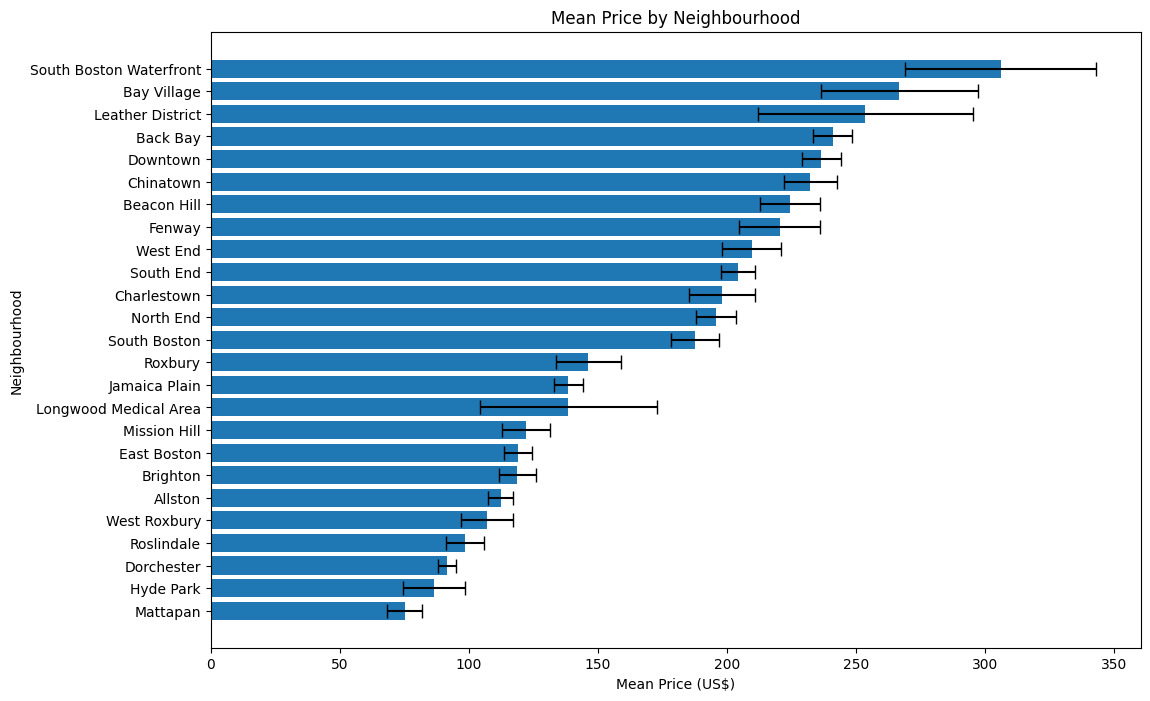

In [82]:
#Subsetting the original dataset for ploting
plot_dataset = listing[['price', 'neighbourhood_cleansed']]

# Group by neighbourhood and calculate the mean price and standard error
grouped = plot_dataset.groupby('neighbourhood_cleansed')['price']
mean_prices = grouped.mean()
std_err = grouped.sem()


# Sort the mean prices by neighbourhood in ascending order
sorted_mean_prices = mean_prices.sort_values()

# Plot the sorted mean prices with error bars as horizontal bars
plt.figure(figsize=(12, 8))
plt.barh(sorted_mean_prices.index, sorted_mean_prices, xerr=std_err.reindex(sorted_mean_prices.index), capsize=5)
plt.title('Mean Price by Neighbourhood')
plt.xlabel('Mean Price (US$)')
plt.ylabel('Neighbourhood')
plt.show()


We can see the that the prices range from a bit less than 100$ to almost 300$. It is clear that the neighborhood is a significant factor in establishing an Airbnb price in Boston.

#### What about correlations?
Verifying how the variables are correlated can give us some idea of what variables affect prices. So, let's quickly plot a heatmap to analyze it.

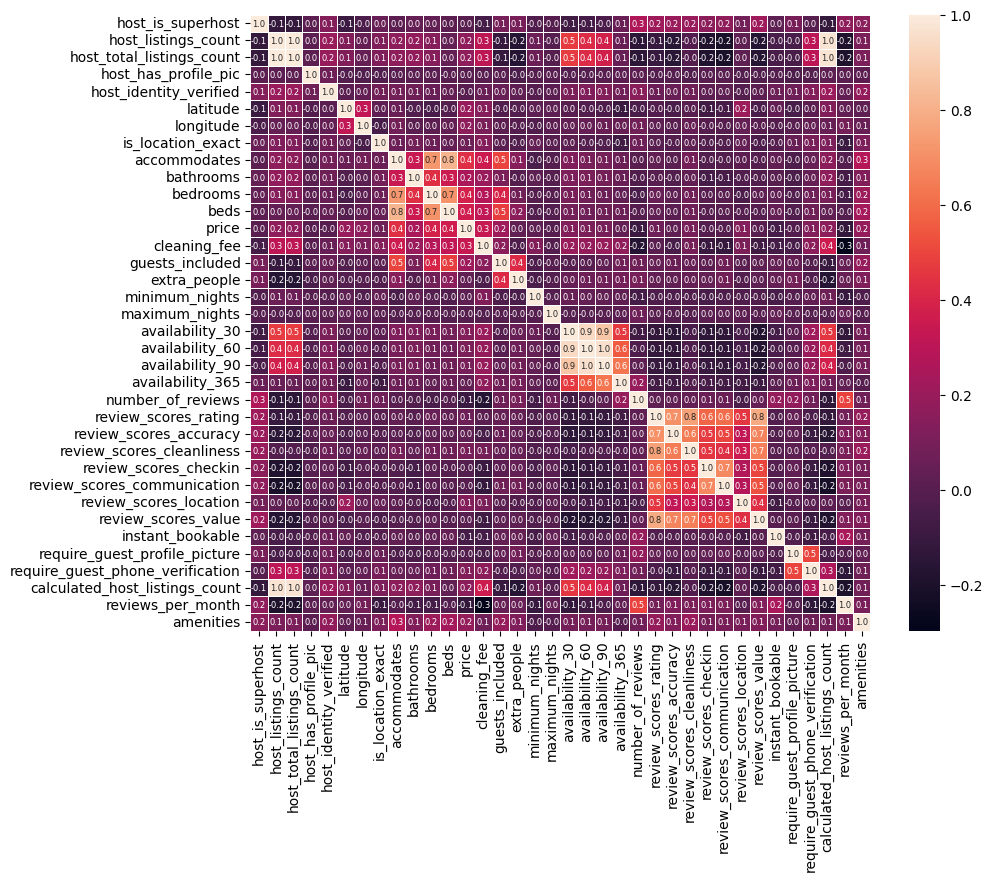

In [69]:
# create a correlation matrix from the input data, including only numeric data types
corr_matrix = data_imputed.select_dtypes(include=['int64', 'float64']).corr()

# plot the correlation heatmap with clustering
# set the figure size to 10 x 8 inches
plt.figure(figsize=(10, 8))

# create a heatmap using Seaborn, with annotations of correlation coefficients rounded to one decimal point
cg = sb.heatmap(corr_matrix, annot=True, fmt='.1f', linewidths=.5, annot_kws={"fontsize":6})

# show the plot
plt.show()

From the heatmap above, we can see that in the row price, the most correlated variables are: accommodates, bedrooms, and beds. Certainly, we should keep those in our model. 
Also, we can see that we have a few variables showing multicollinearity. Since those are problematic and redundant for our model, I will drop those variables and will keep only one of them. One example is the variable host_listing_counts and host_total_listing_count.

In [70]:
#Dropping variables with multicollinearity
data_imputed.drop(['host_listings_count','availability_90','host_total_listings_count'],axis=1,inplace=True)

<a id="17"></a>
### Modeling and Evaluation
Now that we have nicely prepared our dataset, we are good to start testing some models. In the first model, we will include all the variables and predict the data using a Linear Regression, a random forest regressor, or Ridge.


In [71]:
#Split into explanatory and response variables
#ref: https://scikit-learn.org/stable/common_pitfalls.html
y = data_imputed['price']
X = data_imputed.drop(columns=['price'])

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# Making a list with models the iterate through them 
models = [
    LinearRegression(normalize=True),
    RandomForestRegressor(n_estimators=100, random_state=42),
    Ridge(alpha=1.0, normalize=True)
]

#If pipeline is not used a warning message will be showed.
pipelines = []
for model in models:
    pipelines.append(Pipeline([('scaler', StandardScaler()), ('model', model)]))

#Creating empty containers to store the results
model_1 = None
features_mod_1=[]
model_1_r2 = -float('inf')


# iterate over a list of machine learning models
for pipeline in pipelines:
    # fit the current model to the training data
    pipeline.fit(X_train, y_train)
    
    # use the current model to predict the test set targets
    y_test_preds = pipeline.predict(X_test)
    
    # calculate the R-squared score between the true and predicted test set targets
    r2 = r2_score(y_test, y_test_preds)
    
    # if the current model has a higher R-squared score than the previous best model, update the best model and R-squared score
    if r2 > model_1_r2:
        model_1_r2 = r2
        model_1 = pipeline
        features_mod_1=X_train.columns


print(f"Best model: {type(model_1.named_steps['model']).__name__}, R-squared: {model_1_r2}")


Best model: LinearRegression, R-squared: 0.4335833774490192


The selected model was a linear regression, yielding an r-squared of 0.43. Which is not bad, given the amount of NaNs in our dataset.

Now, let's see if deleting some features increases the model accuracy. Below, I will use the function RFE to find the amount of features that leads to the highest accuracy.

In [72]:
##Using selectKbest

# Creating empty containers to store the results
features_mod_2 = []
model_2_r2 = [0]
plot_features = [[], []]

# Storing the total amount of features
all_features_amount = len(X_train.columns)

# Loop over the number of features to select
for amount in range(1, all_features_amount):

    # Instantiate linear regression model
    model = Pipeline([("scaler", StandardScaler(with_mean=False)), ("regressor", LinearRegression())])

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Instantiate SelectKBest -- another option here is using the function RFE
    selector = SelectKBest(f_regression, k=amount)

    # Fit the selector to the training data (The way of indexing is because of the pipeline)
    selector.fit(model.steps[0][1].transform(X_train), y_train)

    # Select the selected features
    selected_features = X_train.columns[selector.get_support()]

    # Fit the model using only the selected features
    model_2_fit = model.fit(X_train[selected_features], y_train)

    # Predict on test data
    y_test_preds = model.predict(X_test[selected_features])

    # Calculate the R^2 score of the model
    r2 = r2_score(y_test, y_test_preds)

    # Append the number of features and the R^2 score to the plot_features list
    plot_features[0].append(amount)
    plot_features[1].append(r2)

    # Update the best model if the current R^2 score is higher
    if r2 > model_2_r2:
        features_mod_2 = selected_features
        model_2 = model
        model_2_r2 = r2

print(f"Best model contains: {len(features_mod_2)} features, R-squared: {model_2_r2}")


Best model contains: 61 features, R-squared: 0.4381706535899581


Text(30, 0.35, 'Best feature amount: 61')

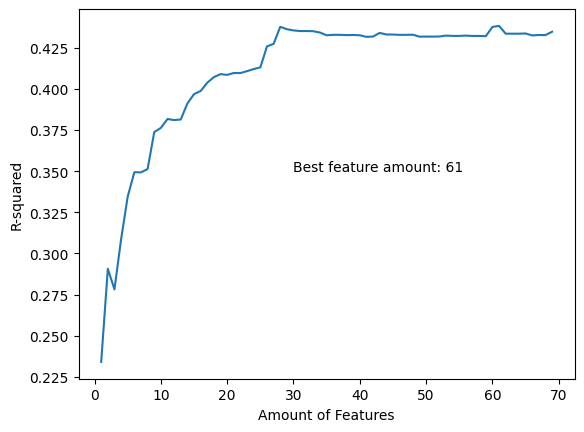

In [73]:
# Plot the R-squared score against the number of features used
plt.plot(plot_features[0], plot_features[1])
# Label the x-axis
plt.xlabel('Amount of Features')
# Label the y-axis
plt.ylabel('R-squared')
# Annotate the plot with the best feature amount and its corresponding R-squared score
plt.annotate(f"Best feature amount: {len(features_mod_2)}", xy=(30, 0.35))


The best model includes 61 variables instead of 70 like before. Let's find out below what features were dropped. 

In [74]:
dropped_features = set(features_mod_1) - set(features_mod_2)
print(f"Dropped features:{dropped_features}")

Dropped features:{'review_scores_value', 'host_is_superhost', 'host_has_profile_pic', 'Loft', 'Longwood Medical Area', 'Leather District', 'minimum_nights', 'maximum_nights', 'Villa'}


Although those dropped variables seem not to influence price prediction, the r-squared was pretty much the same as the previous model. This indicates that the model did not significantly improve. 

<a id="17"></a>
### Answering the question

The question was whether we could predict the Airbnb prices. In summary, I would say YES, we can predict prices. However, given our dataset, the accuracy of the prediction is limited. 
Let's investigate further how some features affect the prices in Boston. 

In [75]:
# Create dictionary to store feature coefficients
coef_data = {'Feature': [], 'Coefficient': [], 'Absolute_Coefficient': []}

# Add feature coefficients to dictionary
coef_data['Feature'] = list(features_mod_2)
coef_data['Coefficient'] = list(model_2.steps[-1][1].coef_)
coef_data['Absolute_Coefficient'] = list(abs(model_2.steps[-1][1].coef_))

# Create table using pandas DataFrame
coef_df = pd.DataFrame(coef_data)
coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)
pd.set_option('display.max_rows', 100)
coef_df.head(len(features_mod_2))


,Feature,Coefficient,Absolute_Coefficient
6,bedrooms,28.591174,28.591174
36,Private room,-27.154350,27.154350
2,longitude,22.735136,22.735136
48,Fenway,17.501802,17.501802
39,Back Bay,17.113692,17.113692
47,East Boston,-15.798014,15.798014
45,Dorchester,-15.695193,15.695193
5,bathrooms,13.969108,13.969108
57,South Boston Waterfront,13.517116,13.517116
24,calculated_host_listings_count,-12.747924,12.747924


With the investigated model we can indeed predict the prices of Airbns in Boston.
In the table above each row represents a feature (i.e., characteristic of the rental property or location), and the corresponding coefficient indicates how strongly that feature affects the rental price.

For example, the first row shows that an addition of bedroom increases the price by \\$28, whereas staying in a non-private room decreases the rental by \\27$. In addition, longitude (west-east) has a coefficient of 22.85, which means that for each unit increase in longitude (going east), the rental price is expected to increase by \\$22.85. Similarly, we can see a coefficient for each neighborhood. For instance, renting an Airbnb in Fenway is \\$17.5 more expensive than Allston (the reference neighborhood), if all the other variables are constant.

Some features have negative coefficients, indicating that they decrease the rental price. For example, Dorchester has a coefficient of -15.72, meaning that a property located in Dorchester is expected to have a lower rental price than a similar property located elsewhere. Similarly, if one shares a room.



<a id="19"></a>
## Conclusion

Through this data analysis, we have gained a better understanding of Boston and how data science can be used to analyze the Airbnb market. It is clear that a complex business like Airbnb requires frequent data analysis to gain insights into customer and owner behavior.

We found that the number of listings in a neighborhood is correlated with the number of bookings, but the neighborhood of Dorchester has a high number of listings but relatively few bookings, indicating a need for restructuring. Boston also has distinct neighborhoods with varying atmospheres, from park-filled areas to bustling party scenes.

Our analysis also revealed that prices can be predicted based on several factors, including neighborhood and amenities. However, it is important to note the original dataset contained a relatively high amount of missing values. This certainly decrease accuracy of our model. Still this analysis demonstrated the power of data science in extracting valuable insights from complex datasets.